# Data downloaden van api.data.amsterdam.nl

Er zijn veel openbare datasets te vinden over de stad Amsterdam en een aantal kan je ophalen via een API van de gemeente. Als je in een browser navigeert naar *https://api.data.amsterdam.nl* zie je het beschikbare aanbod en onder *https://api.data.amsterdam.nl/vsd* vinden we nog enkele extra opties. 

In dit tech report laten we zien hoe je alle oplaadpunten voor elektrische auto's kan ophalen en hun actuele status. Als je dit notebook wil downloaden om er zelf mee verder te werken: rechterklik op 'Raw'-knopje bovenaan en kies dan 'Link opslaan als'.

In [101]:
#import packages
import pandas as pd
import numpy as np
import requests
from shapely.geometry import Point
import geopandas as gpd
import contextily as cx

Uit de tweede pagina genoemd in de inleiding zien we dat het API-adres van de oplaadpunten *https://api.data.amsterdam.nl/vsd/oplaadpunten/* is. We kunnen de inhoud hiervan opvragen met een GET request (hetzelfde als wat een browser doet, je kan het dus ook testen door de url in een nieuw tabblad te plakken). 

In python gebruiken we de **get()** functie uit het requests package en met de **.json()** methode wordt de inhoud van de response omgezet naar een python dictionary. We bekijken enkele keys uit de dictionary: 

In [116]:
response = requests.get('https://api.data.amsterdam.nl/vsd/oplaadpunten/').json()
response['_links']

{'self': {'href': 'https://api.data.amsterdam.nl/vsd/oplaadpunten/'},
 'next': {'href': 'https://api.data.amsterdam.nl/vsd/oplaadpunten/?page=2'},
 'previous': {'href': None}}

In [117]:
response['count']

4784

In [118]:
len(response['results'])

20

In [115]:
response['results'][0]

{'_links': {'self': {'href': 'https://api.data.amsterdam.nl/vsd/oplaadpunten/1/',
   'title': 'Allego - Loevesteinse Randweg 200'}},
 '_display': 'Allego - Loevesteinse Randweg 200',
 'id': 1,
 'cs_external_id': 'NLALLEGO001520',
 'wkb_geometry': {'type': 'Point',
  'coordinates': [114469.02282669621, 481642.610107823]},
 'street': 'Loevesteinse Randweg',
 'housenumber': '200',
 'housnumberext': None,
 'postalcode': '1118EL',
 'district': None,
 'countryiso': 'NLD',
 'region': None,
 'city': 'Schiphol',
 'provider': 'Allego',
 'restrictionsremark': None,
 'charging_point': 3,
 'status': 'Faulted',
 'connector_type': 'IEC_62196_T2_COMBO;CHADEMO;IEC_62196_T2',
 'vehicle_type': '',
 'charging_capability': '50.0;43.0',
 'identification_type': 'CCS;CHADEMO;TYPE_2',
 'last_update': '2022-12-05T14:40:10.199968Z',
 'last_status_update': '2023-01-10T10:39:10.282520Z',
 'charging_cap_max': 50.0,
 'name': 'Allego - Loevesteinse Randweg 200'}

Hierin zien we het totaal aantal laadpunten in de dataset (onder 'count') en ook de eerste 20 resultaten. De resultaten zijn dus gepagineerd (de volgende 20 staan op page 2), we zullen dus een loop moeten schrijven om alles op te halen. Eerst schrijven een functie die een enkele pagina opvraagt en de resultaten één voor één naar een pandas DataFrame omzet (dit moet één voor één omdat de structuur niet tabelvormig is, de waarde bij key 'wkb_geometry' is bijv zelf weer een dictionary).

In [85]:
def get_page(url):
    call = requests.get(url).json()
    next_page = call['_links']['next']['href']
    df = pd.concat([pd.DataFrame([call['results'][i]]) for i in range(len(call['results']))])
    return df, next_page

In [86]:
get_page('https://api.data.amsterdam.nl/vsd/oplaadpunten/')[0].head()

,_links,_display,id,cs_external_id,wkb_geometry,street,housenumber,housnumberext,postalcode,district,...,charging_point,status,connector_type,vehicle_type,charging_capability,identification_type,last_update,last_status_update,charging_cap_max,name
0,{'self': {'href': 'https://api.data.amsterdam....,Allego - Loevesteinse Randweg 200,1,NLALLEGO001520,"{'type': 'Point', 'coordinates': [114469.02282...",Loevesteinse Randweg,200,None,1118EL,None,...,3,Faulted,IEC_62196_T2_COMBO;CHADEMO;IEC_62196_T2,,50.0;43.0,CCS;CHADEMO;TYPE_2,2022-12-05T14:40:10.199968Z,2023-01-10T10:39:10.282520Z,50.0,Allego - Loevesteinse Randweg 200
0,{'self': {'href': 'https://api.data.amsterdam....,Allego - Strawinskylaan 2,2,NLALLEGO006003,"{'type': 'Point', 'coordinates': [120110.35451...",Strawinskylaan,2,None,1077XW,None,...,3,Available,CHADEMO;IEC_62196_T2_COMBO;IEC_62196_T2,,50.0;43.0,CHADEMO;CCS;TYPE_2,2022-12-05T14:55:11.452158Z,2023-01-10T10:39:10.282520Z,50.0,Allego - Strawinskylaan 2
0,{'self': {'href': 'https://api.data.amsterdam....,Allego - Flakkeestraat 79,3,NLALLEGO001190,"{'type': 'Point', 'coordinates': [119569.47211...",Flakkeestraat,79,None,1181CH,None,...,2,Available,IEC_62196_T2,,11.0,TYPE_2,2022-12-05T18:55:18.947279Z,2023-01-10T10:39:10.282520Z,11.0,Allego - Flakkeestraat 79
0,{'self': {'href': 'https://api.data.amsterdam....,Allego - Dorpsstraat 32,4,NLALLEGO001166,"{'type': 'Point', 'coordinates': [118176.99418...",Dorpsstraat,32,None,1182JE,None,...,2,Available,IEC_62196_T2,,11.0,TYPE_2,2022-12-05T16:10:09.416164Z,2023-01-10T10:39:10.282520Z,11.0,Allego - Dorpsstraat 32
0,{'self': {'href': 'https://api.data.amsterdam....,Allego - transformatorweg 28,6,NLALLEGO006000,"{'type': 'Point', 'coordinates': [118689.02629...",transformatorweg,28,None,1014AK,None,...,3,Available,IEC_62196_T2_COMBO;CHADEMO;IEC_62196_T2,,50.0;43.0,CCS;CHADEMO;TYPE_2,2022-12-05T16:25:09.190611Z,2023-01-10T10:39:10.282520Z,50.0,Allego - transformatorweg 28


Nu gaan we een loop schrijven die alle pagina's afgaat tot er geen volgende pagina meer is. Hierbij maken we gebruik van de de key 'next', onder '\_links' waarin het adres staat van de volgende pagina. Deze hadden we al ingebouwd in de functie. 

In [96]:
df_list = []
url = 'https://api.data.amsterdam.nl/vsd/oplaadpunten/'

while url is not None:
    df_temp, url = get_page(url)
    df_list.append(df_temp)

df_final = pd.concat(df_list)
df_final.shape

(4784, 25)

We zien dat het uiteindelijke dataframe precies evenveel rijen heeft als de waarde die we eerder bij 'count' zagen staan. Het is dus gelukt om alle datapunten binnen te halen. 

Eigenlijk zijn we nu klaar, maar het is handig om de ruimtelijke gegevens van de oplaadpunten nog op de juiste manier te verwerken. Nu zijn het nog gewoon getalletjes, maar kunnen deze interpreteren in het bijbehorende coordinatenstelsel. Als we naar het eerste datapunt kijken zien we dat de getallen in de orde van 100.000 zijn, niet de GPS-coordinaten die je misschien gewend bent maar het rijksdriehoekstelsel.

We maken gebruik van het package shapely om de punt-geometrie in te laden en het package geopandas om deze punten in het juiste coordinatenstelsel te zetten: 

In [97]:
df_final.wkb_geometry.iloc[0]

{'type': 'Point', 'coordinates': [114469.02282669621, 481642.610107823]}

In [99]:
df_final['geometry'] = df_final.wkb_geometry.apply(lambda x: Point(x['coordinates']))
gdf = gpd.GeoDataFrame(df_final).set_crs(28992)

We kunnen nu een kaartje maken om de oplaadpunten te visualiseren (we filteren even op postcodes die met het getal '1' beginnen want er blijken ook enkele oplaadpunten buiten amsterdam in de dataset te zitten).

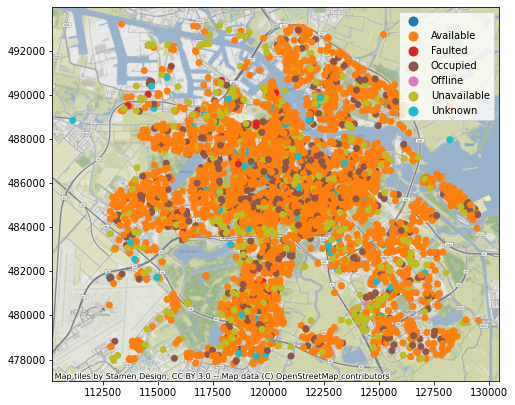

In [113]:
ax = gdf.loc[gdf.postalcode.str[0] == '1'].plot(figsize=(8, 8), column = 'status', legend=True)
cx.add_basemap(ax,crs=gdf.crs)